# Trabajo Final - Redes Neuronales

## Importo las librerias necesarias


In [ ]:
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import scipy as sp
import scipy.linalg as linalg
import sklearn as skl
import pandas as pd
import json

In [ ]:
# 1.3)
import torch
import torch.optim as optim
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader, Subset, random_split
from torchvision import datasets
from torchvision import transforms
from torchvision.io import read_image
from torchvision.transforms import ToTensor, Lambda, Compose

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

## Red neuronal autoencoder convolucional de varias capas

### Importo data set

In [4]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])

PATH = 'MNIST_data/'
train_set_orig = datasets.FashionMNIST(PATH, download=True, train=True, transform=transform)
valid_set_orig = datasets.FashionMNIST(PATH, download=True, train=False, transform=transform)

100%|██████████| 26.4M/26.4M [00:41<00:00, 632kB/s] 


Extracting MNIST_data/FashionMNIST/raw/train-images-idx3-ubyte.gz to MNIST_data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 109kB/s]


Extracting MNIST_data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to MNIST_data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:02<00:00, 1.83MB/s]


Extracting MNIST_data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to MNIST_data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 18.4MB/s]

Extracting MNIST_data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST_data/FashionMNIST/raw



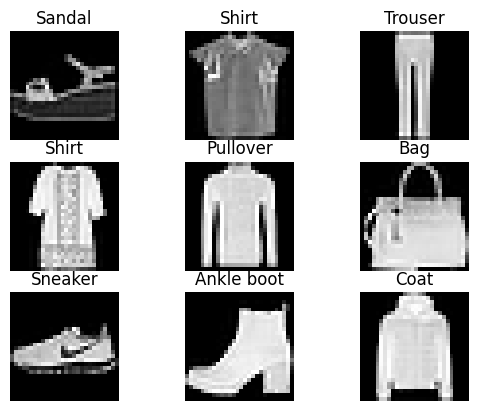

In [6]:
figure = plt.figure()
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    j = torch.randint(len(train_set_orig), size=(1,)).item()
    image, label = train_set_orig[j]
    figure.add_subplot(rows, cols, i)
    plt.title(train_set_orig.classes[label])
    plt.axis("off")
    plt.imshow(image.squeeze(), cmap="gray")
plt.show()

### Creo data set personalizado

In [7]:
class CustomDataset():
    def __init__(self, dataset):
        self.dataset = dataset
    def __len__(self):
        return len(self.dataset)
    def __getitem__(self, i):
        image, label = self.dataset[i]
        input = image
        output = image
        return input, output

In [8]:
train_set = CustomDataset(train_set_orig)
valid_set = CustomDataset(valid_set_orig)

### Parte 1: red autoencoder

In [11]:
def to_ndim(ndim, i):
    '''
    Mapea un entero i a una tupla (i, i, ..., i) de longitud ndim.
    '''
    if isinstance(i, int):
        return tuple([i]*ndim)
    else:
        return i

to_ndim(3, 10)

(10, 10, 10)

In [15]:
def conv_size(ndim, in_size, kernel_size, stride=1, padding=0, dilation=1):
    '''
    Calcula el tamaño de la salida de una capa de convolución.
    '''
    in_size = to_ndim(ndim, in_size)
    kernel_size = to_ndim(ndim, kernel_size)
    stride = to_ndim(ndim, stride)
    padding = to_ndim(ndim, padding)
    dilation = to_ndim(ndim, dilation)
    out_size = [(in_size[i] + 2*padding[i] - dilation[i]*(kernel_size[i] - 1) - 1)//stride[i] + 1 for i in range(ndim)]
    return out_size

def conv_tr_size(ndim, in_size, kernel_size, stride=1, padding=0, dilation=1, output_padding=0):
    '''
    Calcula el tamaño de la salida de una capa de convolución transpuesta.
    '''
    in_size = to_ndim(ndim, in_size)
    kernel_size = to_ndim(ndim, kernel_size)
    stride = to_ndim(ndim, stride)
    padding = to_ndim(ndim, padding)
    dilation = to_ndim(ndim, dilation)
    output_padding = to_ndim(ndim, output_padding)
    out_size = [(in_size[i] - 1)*stride[i] - 2*padding[i] + dilation[i]*(kernel_size[i] - 1) + output_padding[i] + 1 for i in range(ndim)]
    return out_size

In [16]:
conv_tr_size(2, 13, 4, stride=2)

[28, 28]

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self, n, p=0.2):
        super(Autoencoder, self).__init__()
        self.flatten = nn.Flatten()
        self.encoder = nn.Sequential(
            # convolutional
            nn.Conv2d(1, 16, kernel_size=3, padding=0), #1x28x28 -> 16x26x26
            nn.ReLU(),
            nn.Dropout(p),
            nn.MaxPool2d(kernel_size=2, stride=2), #16x26x26 -> 16x13x13
            #  Conv2
            nn.Conv2d(16, 32, kernel_size=3, padding=0), #16x13x13 -> 32x11x11
            nn.ReLU(),
            nn.Dropout(p),
            nn.MaxPool2d(kernel_size=2, stride=2), #32x11x11 -> 32x5x5
            # Lineal
            nn.Flatten(), #32x5x5 -> 800
            nn.Linear(32*5*5, n), #800 -> n
            nn.ReLU(),
            nn.Dropout(p)
        )
        self.decoder = nn.Sequential(
            # lineal
            nn.Linear(n, 32*5*5), #n -> 800
            nn.ReLU(),
            nn.Dropout(p),
            nn.Unflatten(1, (32, 5, 5)), #800 -> 32x5x5

            # convolutional 2 transpuesta
            nn.ConvTranspose2d(32, 16, kernel_size=4, stride=2, output_padding=1), #32x5x5 -> 16x13x13
            nn.ReLU(),
            nn.Dropout(p),

            # convolutional 1 transpuesta
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, output_padding=1),  # 16x13x13 -> 1x28x28
            nn.ReLU(),
            nn.Dropout(p)
        )
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [ ]:
n = 64
p = 0.2
model_autoencoder = Autoencoder(n, p=p)
model = model_autoencoder

def batch(x):
    return x.unsqueeze(0)

def unbatch(x):
    return x.squeeze().detach().cpu().numpy()


In [ ]:
unbatch(modelo(batch(train_set[0][0]))).shape #28,28

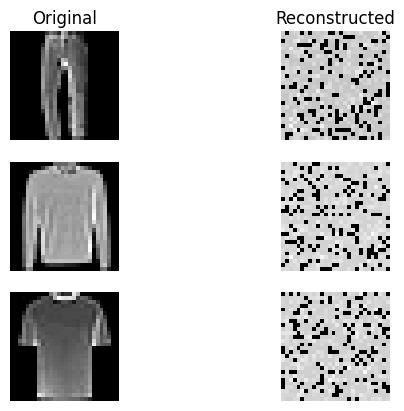

In [25]:
# miramos que imagene predice el modelo sin entrenar
figure = plt.figure()
rows, cols = 3, 2
i = 0
for row in range(1, rows + 1):
    j = torch.randint(len(train_set), size=(1,)).item()
    i += 1
    image, _ = train_set[j]
    figure.add_subplot(rows, cols, i)
    if row == 1:
        plt.title('Original')
    plt.axis("off")
    plt.imshow(image.squeeze(), cmap="gray")
    i += 1
    figure.add_subplot(rows, cols, i)
    if row == 1:
        plt.title('Reconstructed')
    plt.axis("off")
    image_pred = unbatch(model(batch(image)))
    plt.imshow(image_pred.squeeze(), cmap="gray")
plt.show()

## Parte 2: entrenenado el autoencoder

In [ ]:
def train_model(dataloader, model, loss_fn, optimizer):
    num_samples = len(dataloader.dataset)
    num_batches = len(dataloader)
    sum_batch_avrg_loss = 0
    sum_correct = 0
    num_processed_samples = 0

    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        batch_size = len(X)
        pred = model(X)
        loss = loss_fn(pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        batch_avrg_loss = loss.item()
        sum_batch_avrg_loss += batch_avrg_loss
        sum_correct += (pred.argmax(dim=1) == y).type(torch.float).sum().item()
        num_processed_samples += batch_size

        # if batch % (num_batches/10) == 0:
        # if batch % max(num_batches // 10, 1) == 0:
        #    print(f'Batch {batch:>5d} | Loss: {batch_avrg_loss:.6f} | '
        #          f'Processed: {100 * num_processed_samples / num_samples:.2f}%')

    avg_loss = sum_batch_avrg_loss / num_batches
    precision = sum_correct / num_samples
    return avg_loss, precision


def valid_model(dataloader, model, loss_fn):
    num_samples = len(dataloader.dataset)
    num_batches = len(dataloader)
    sum_batch_avrg_loss = 0
    sum_correct = 0

    model.eval()
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            loss = loss_fn(pred, y)
            sum_batch_avrg_loss += loss.item()
            sum_correct += (pred.argmax(dim=1) ==
                            y).type(torch.float).sum().item()

    avg_loss = sum_batch_avrg_loss / num_batches
    precision = sum_correct / num_samples
    print(f'Validation | Precision: {100 * precision:.1f}% | Avg Loss: {avg_loss:.6f}')
    return avg_loss, precision

In [ ]:
# creamos los dataloaders
BATCH_SIZE = 100
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid_set, batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
# creamos una instancia de la funcion de perdida, 
# loss_fn = nn.CrossEntropyLoss()
loss_fn = nn.MSELoss()

In [ ]:
# creamos el modelo
n = 64
p = 0.2
model = Autoencoder(n, p=p)

In [ ]:
# learning rate
lr = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=lr, eps=1e-8, weight_decay=0, amsgrad=False)
# optimizer = torch.optim.SGD(model.parameters(), lr=lr)

In [ ]:
# 2.8)
num_epochs = 30
list_train_avg_loss = []
list_valid_avg_loss = []
list_train_precision = []
list_valid_precision = []

for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}\n' + '-' * 20)

    train_avg_loss, train_precision = train_model(
        train_loader, model, loss_fn, optimizer)
    valid_avg_loss, valid_precision = valid_model(valid_loader, model, loss_fn)

    list_train_avg_loss.append(train_avg_loss)
    list_valid_avg_loss.append(valid_avg_loss)
    list_train_precision.append(train_precision)
    list_valid_precision.append(valid_precision)

print('Entranamiento completo')

In [ ]:
# guardo el modelo
torch.save(model.state_dict(), 'model_base.pth')

In [ ]:
baseline_train_loss = list_train_avg_loss
baseline_valid_loss = list_valid_avg_loss
baseline_train_precision = list_train_precision
baseline_valid_precision = list_valid_precision

In [ ]:
plt.figure(figsize=(4, 6))
plt.subplot(2, 1, 1)  # Crear un subplot en la posición (1, 1)
plt.title('a)', loc='left')
plt.ylabel('Pérdida')
plt.plot(range(1, len(baseline_train_loss)+1),
         baseline_train_loss, label=f'Entranamiento')
plt.plot(range(1, len(baseline_valid_loss)+1),
         baseline_valid_loss, label=f'Validación')
plt.ylim(0.2, 2.2)
plt.grid(alpha=0.5)
plt.legend(loc='upper right', fontsize='x-small')

plt.subplot(2, 1, 2)  # Crear un subplot en la posición (2, 1)
plt.title('b)', loc='left')
plt.ylabel('Precisión')
plt.plot(range(1, len(baseline_train_precision)+1),
         baseline_train_precision, label=f'Entranamiento')
plt.plot(range(1, len(baseline_valid_precision)+1),
         baseline_valid_precision, label=f'Validación')
plt.ylim(0.35, 0.95)
plt.grid(alpha=0.5)
plt.legend(loc='lower right', fontsize='x-small')

plt.xlabel('Número de épocas')  # Agregar el label solo una vez
plt.tight_layout()  # Ajustar el tamaño de los subplots
plt.savefig('baseline.png', dpi=300, bbox_inches='tight')
plt.show()

## Variar algunos parametros

## Parte 3: Definiendo un clasificador convolucional reutilizando el encoder

In [ ]:
#3.1
class Autoencoder_clasificator(nn.Module):
    def __init__(self, n, p=0.2, encoder=None):
        super(Autoencoder_clasificator, self).__init__()
        self.flatten = nn.Flatten()
        if encoder is None:
            self.encoder = nn.Sequential(
                # convolutional
                nn.Conv2d(1, 16, kernel_size=3, padding=0), #1x28x28 -> 16x26x26
                nn.ReLU(),
                nn.Dropout(p),
                nn.MaxPool2d(kernel_size=2, stride=2), #16x26x26 -> 16x13x13
                #  Conv2
                nn.Conv2d(16, 32, kernel_size=3, padding=0), #16x13x13 -> 32x11x11
                nn.ReLU(),
                nn.Dropout(p),
                nn.MaxPool2d(kernel_size=2, stride=2), #32x11x11 -> 32x5x5
                # Lineal
                nn.Flatten(),
                nn.Linear(32*5*5, n),
                nn.ReLU(),
                nn.Dropout(p)
            )
        else:
            self.encoder = copy.deepcopy(encoder)
        self.classifier = nn.Sequential(
            nn.Linear(n, 10),
            nn.ReLU(),
            nn.Dropout(p)
        )
    def forward(self, x):
        x = self.encoder(x)
        x = self.classifier(x)
        return x

In [ ]:
train_loader = DataLoader(train_set_orig, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid_set_orig, batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
#3.3
loss_fn = nn.CrossEntropyLoss()

In [ ]:
#3.4
n = 64
p = 0.2
model_cla_auto = Autoencoder_clasificator(n, p=p, encoder=model_autoencoder.encoder)

In [ ]:
lr = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=lr, eps=1e-8, weight_decay=0, amsgrad=False) #reentrena todo

In [ ]:
# 3.2)
num_epochs = 30
list_train_avg_loss = []
list_valid_avg_loss = []
list_train_precision = []
list_valid_precision = []

for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}\n' + '-' * 20)

    train_avg_loss, train_precision = train_model(
        train_loader, model, loss_fn, optimizer)
    valid_avg_loss, valid_precision = valid_model(valid_loader, model, loss_fn)

    list_train_avg_loss.append(train_avg_loss)
    list_valid_avg_loss.append(valid_avg_loss)
    list_train_precision.append(train_precision)
    list_valid_precision.append(valid_precision)

print('Entranamiento completo')

In [ ]:
# modificar
baseline_train_loss = list_train_avg_loss
baseline_valid_loss = list_valid_avg_loss
baseline_train_precision = list_train_precision
baseline_valid_precision = list_valid_precision

In [ ]:
# matriz de confusion
import seaborn as sns


def confusion_matrix(model, dataloader):
    num_samples = len(dataloader.dataset)
    num_classes = 10
    confusion_matrix = torch.zeros(num_classes, num_classes)
    model.eval()
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            pred = pred.argmax(dim=1)
            for i in range(len(y)):
                confusion_matrix[y[i], pred[i]] += 1
    return confusion_matrix


# grafico de matriz don seaborn


def plot_confusion_matrix(confusion_matrix, labels):
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_matrix, annot=True, fmt='g',
                cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicción')
    plt.ylabel('Real')
    plt.title('Matriz de confusión')
    plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
    plt.show()


labels = [labels_names[i] for i in range(10)]

confusion_matrix = confusion_matrix(model, valid_loader)
plot_confusion_matrix(confusion_matrix, labels)

## Parte 4


In [ ]:
# Modifique el optimizador para que s´olo reentrene los par´ametros de la capa clasificadora, dejando los
# par´ametros de la capa codificadora tal como vienen entrenada del el autoencoder convolucional. Repita
# los experimentos de la parte 3. Que observa? Comente

# 3.4)
n = 64
p = 0.2
lr = 1e-3

optimizer = torch.optim.Adam(model.clasificador.parameters(), lr=lr, eps=1e-8, weight_decay=0, amsgrad=False)  # solo clasificador da peor